<h1>Supervised Learning-Classification Model Development</h1>

<em><strong>Roberto Zevallos</strong></em>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

To start, I imported all the required functions for the different regression classifiers, scores and confusion matrix. Additionally, I read the Game of Thrones character predictions Excel file.
<br>

In [1]:
# importing libraries
import numpy as np
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning
from sklearn.metrics import make_scorer                # customizable scorer

# loading data
GOT = pd.read_excel('./GOT_character_predictions.xlsx')

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# displaying the head of the dataset
GOT.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


<br>
<strong>User defined functions</strong>
<br>
The following section is used to define variables that will be used throughout the code for flagging the missing values, calculating the optimal number of neighbors for KNN model, developing a visual confusion matrix, and plotting the feature importance for CART models.
<br>

In [2]:
#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df      
        
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df

    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)

    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []  
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)

    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")   
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))

    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)

    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

#########################################
# feature importance
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_Feature_Importance.png')

<br>
Then the .info() function helped me check the information of my data, like validation of data types and observing the high amount of missing values. From this it was already easy to determine that the <em>S.No</em> feature should be dropped since it is only showing a character number by order of appearance. Dropping this column as soon as possible helps me to not consider it by mistake in any further analysis. 
<br><br>
Next, I checked the size of my dataset, where I identified that it does have a good amount of observations (1946) and 24 features.
<br><br>
By using the .isnull() function I identified missing values in 13 features which is a big number to deal with in the following feature engineering section.
<br>

In [3]:
GOT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S.No                        1946 non-null   int64  
 1   name                        1946 non-null   object 
 2   title                       938 non-null    object 
 3   culture                     677 non-null    object 
 4   dateOfBirth                 433 non-null    float64
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1519 non-null   object 
 9   spouse                      276 non-null    object 
 10  book1_A_Game_Of_Thrones     1946 non-null   int64  
 11  book2_A_Clash_Of_Kings      1946 non-null   int64  
 12  book3_A_Storm_Of_Swords     1946 non-null   int64  
 13  book4_A_Feast_For_Crows     1946 

In [4]:
# dropping order variable
GOT = GOT.drop(labels = 'S.No',
                       axis   = 1)

In [5]:
print(f"""
Size of Original Dataset
------------------------
Observations: {GOT.shape[0]} 
Features:     {GOT.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946 
Features:     24



In [6]:
# checking each feature for missing values
GOT.isnull().sum(axis = 0)

name                             0
title                         1008
culture                       1269
dateOfBirth                   1513
mother                        1925
father                        1920
heir                          1923
house                          427
spouse                        1670
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveMother                 1925
isAliveFather                 1920
isAliveHeir                   1923
isAliveSpouse                 1670
isMarried                        0
isNoble                          0
age                           1513
numDeadRelations                 0
popularity                       0
isAlive                          0
dtype: int64

<br>
<strong>Flagging missing values</strong>
<br>
To point out the missing values I used the previously defined function that adds new columns at the end of the dataset with "1" were the missing values are found. These new columns are codified by adding a letter "m" from missing the beginning of their name.
<br>
The columns function was used to check the results of the function and identify that the missing values columns were created.
<br>

In [7]:
# running the mv_flagger function
GOT = mv_flagger(df = GOT)

# checking results
GOT.columns

Index(['name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir', 'm_isAliveSpouse', 'm_age'], dtype='object')

<br><br>
<strong>Treatment of missing values and Feature Engineering</strong>
<br>
To treat the missing values I created a cell with comments for each feature with possible imputations and categorical encoding that could be used to engineer new features from the original ones.
<br>
It can be seen that the variable type was also identified among with the above mentioned possibilities.
<br>
This comments are applied with more detail in the feature engineering section coming right after.
<br><br>

In [8]:
# analyzing features for missing value imputation and categorical encoding

# name             - (discrete) feature to determine gender, feature to determine house or culture (taking family name)
# title            - (discrete) / missing (missing can be used assuming that they don't have received a title and one-hot encode)
# culture          - (categorical) impute based on split of name (family name), impute based on house OR
#                                  impute with 'Unknown', then one-hot encode / missing
# dateOfBirth      - (continuous) add this variable to age to get the timeframe were this person lived 
#                                 / missing, but first impute this variable with the median
# mother           - (discrete) / missing (drop and used flagging)
# father           - (discrete) / missing (drop and used flagging)
# heir             - (discrete) / missing - impute with "No heir" if it is missing (if the character had a heir worth of
#                                           including, it would have had a name)
# house            - (discrete) impute based on split of name (family name), also impute based on culture OR
#                               impute with 'Unknown', then one-hot encode / missing
# spouse           - (discrete) impute with unknown OR if isMarried = 0 impute with not married OR
#                               impute based if its name appears as other person's spouse / missing
# book 1           - (categorical) use to determine appearances of characters
# book 2           - (categorical) use to determine appearances of characters
# book 3           - (categorical) use to determine appearances of characters
# book 4           - (categorical) use to determine appearances of characters
# book 5           - (categorical) use to determine appearances of characters
# isAliveMother    - (categorical) / missing - could be completed based on a person having or not a mother
# isAliveFather    - (categorical) / missing - could be completed based on a person having or not a father
# isAliveHeir      - (categorical) / missing - can be 0 assuming the information wasn't recorded
# isAliveSpouse    - (categorical) / missing - can be 0 assuming the information wasn't recorded, if someone is not married,
#                                    then this person wouldn't have an alive spouse
# isMarried        - (categorical) use to complete other variables as isAliveSpouse
# isNoble          - (categorical) use to determine if someone is noble or not
# age              - (continuous) add this variable to DOB to get the timeframe were this person lived
#                                 / missing, but first impute this variable with the median
# numDeadRelations - (continuous) drop (maybe is obtained after the fact) OR keep assuming it wasn't taken after the fact
#                                 and use to calculate the number based on the type of culture of the character.
# popularity       - (continuous) drop (maybe is obtained after the fact) OR keep assuming popularity on the story itself
# isAlive          - (categorical) response variable


# family name (strong)     culture                                                  house
# Stark                    Northmen / Rivermen                                      Stark / Tully (1)
# Targaryen                Valyrian                                                 Targaryen
# Lannister                Westerman / Westerlands (Westerman_Westerlands)          Lannister / Lannister of Lannisport (1) / Lannister of Casterly Rock (1) / Baratheon (1) 
# Greyjoy                  Ironborn / Ironmen (Ironborn_Ironmen)                    Greyjoy
# Tyrell                   Reach / The Reach (Reach)                                Tyrell / Tyrell of Brightwater Keep (1) / Citadel (1)
# Baratheon                Stormlands                                               Baratheon / Baratheon of King's Landing (1) / Baratheon of Dragonstone (1)
# Martell                  Dornish / Dornishmen (Dornish)                           Martell / Nymeros Martell (1)
# Arryn                    Vale / Valemen (Valemen)                                 Arryn / Beesbury (1) / Tully (1)
# Tully                    Rivermen                                                 Tully

<br><br>
<strong>Feature Engineering</strong>
<br>
The first engineering that I used was focused on obtaining the first name of each character in order to use it in the gender guesser detector to determine the gender of the characters. It is important to mention that the first word of each name was assumed to be the first name of each character.
<br><br>
Additionally, the following code has been commented out and freezed in order to ensure that it is not run again. However, the output of this code was printed out and included as a list in order to be used as a new feature of the dataset.
<br>

In [ ]:
################################################
# getting first name for gender guesser
#name_split = GOT['name'].str.split(n = 2, expand = True)
#GOT['first_name'] = name_split[0]

#import gender_guesser.detector as gender

#placeholder_lst = []

#for name in GOT['first_name']:
#    guess = gender.Detector().get_gender(name)
#    print(guess)
#    placeholder_lst.append(guess)

#GOT['gender_guess'] = pd.Series(placeholder_lst)

#print(placeholder_lst)

In [9]:
# list of genders obtained by running the gender_guesser.detector
gender_list = ['unknown', 'unknown', 'andy', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown',
               'male', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'andy', 'andy', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown',
               'male', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'male', 'mostly_male',
               'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown',
               'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'female', 'andy', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'andy', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown',
               'unknown', 'female', 'unknown', 'mostly_female', 'female', 'unknown', 'mostly_female', 'unknown',
               'female', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'male', 'male', 'male',
               'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male',
               'female', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male',
               'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female',
               'unknown', 'unknown', 'unknown', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown',
               'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'female',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female',
               'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown',
               'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female',
               'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female',
               'mostly_female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male',
               'male', 'male', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'mostly_male', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'male', 'female', 'unknown', 'unknown',
               'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown',
               'female', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female',
               'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'male', 'female', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female',
               'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'female',
               'mostly_female', 'female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female',
               'mostly_female', 'mostly_female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown',
               'female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'female', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown',
               'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'female', 'mostly_male', 'unknown', 'female', 'male', 'male', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male',
               'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male',
               'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'male', 'female', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown',
               'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female',
               'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male',
               'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'male', 'unknown', 'male', 'male', 'andy', 'male', 'male', 'unknown', 'unknown',
               'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male',
               'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'male', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown',
               'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown',
               'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown',
               'male', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male',
               'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown',
               'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
               'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown',
               'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'mostly_male',
               'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male',
               'unknown', 'unknown']

<br><br>
<strong>Feature Engineering continued</strong>
<br>
After hard coding the output of the gender detector, I began to produce engineered features of the dataset based on the previous mentioned engineering possibilities. The following code shows and explains the process used.
<br>
Also, when developing the models, these lines of code were also run to continue visualizing and validating the developed variables, and engineering new variables or categories.
<br>

In [10]:
################################################
# impute title
GOT['title'].fillna(value = 'No_title', inplace = True)
GOT['title_received'] = np.where(GOT['title'] == 'No_title', 'No_received_title', 'Yes_received_title')
one_hot_title = pd.get_dummies(GOT['title_received'])
GOT = GOT.join([one_hot_title])

################################################
# impute culture based on family name
# looping to find family names
for index, val in GOT.iterrows():
    
    # checking for Stark
    if ' Stark' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Northmen'
        
    # checking for Targaryen
    elif ' Targaryen' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Valyrian'
        
    # checking for Lannister
    elif ' Lannister' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Westerman_Westerlands'
        
    # checking for Greyjoy
    elif ' Greyjoy' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Ironborn_Ironmen'
        
    # checking for Tyrell
    elif ' Tyrell' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Reach'
        
    # checking for Baratheon
    elif ' Baratheon' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Stormlands'
        
    # checking for Martell
    elif ' Martell' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Dornish'
        
    # checking for Arryn
    elif ' Arryn' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Valemen'
        
    # checking for Tully
    elif ' Tully' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'culture_imput'] = 'Rivermen'
        
    # controlling unknown
    else:
        GOT.loc[index, 'culture_imput'] = 'Unknown'
        
# use the culture_imput values to fill missing values of culture (in a new column)
GOT['culture_2'] = GOT['culture']
GOT['culture_2'].fillna(value = GOT['culture_imput'], inplace = True)

strong_cultures = ['Northmen', 'Valyrian', 'Westerman_Westerlands', 'Ironborn_Ironmen', 'Reach', 'Stormlands', 'Dornish', 'Valemen', 'Rivermen']
GOT['strong_culture'] = np.where(GOT['culture_2'].isin(strong_cultures), "culture_Strong", np.where(GOT['culture_2'] == 'Unknown', 'culture_Unknown', 'culture_Other'))
one_hot_culture = pd.get_dummies(GOT['strong_culture'])
GOT = GOT.join([one_hot_culture])

################################################
# impute heir
GOT['heir'].fillna(value = 'No_heir', inplace = True)
GOT['has_heir'] = np.where(GOT['heir'] == 'No_heir', 'No_heir', 'Yes_heir')
one_hot_heir = pd.get_dummies(GOT['has_heir'])
GOT = GOT.join([one_hot_heir])

################################################
# impute house based on family name
# looping to find family names
for index, val in GOT.iterrows():
    
    # checking for Stark
    if ' Stark' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Stark'
        
    # checking for Targaryen
    elif ' Targaryen' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Targaryen'
        
    # checking for Lannister
    elif ' Lannister' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Lannister'
        
    # checking for Greyjoy
    elif ' Greyjoy' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Greyjoy'
        
    # checking for Tyrell
    elif ' Tyrell' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Tyrell'
        
    # checking for Baratheon
    elif ' Baratheon' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Baratheon'
        
    # checking for Martell
    elif ' Martell' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Martell'
        
    # checking for Arryn
    elif ' Arryn' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Arryn'
        
    # checking for Tully
    elif ' Tully' in GOT.loc[ index , 'name']:
        GOT.loc[index, 'house_imput'] = 'House Tully'
        
    # controlling unknown
    else:
        GOT.loc[index, 'house_imput'] = 'Unknown'
              
# use the house_imput values to fill missing values of culture (in a new column)
GOT['house_2'] = GOT['house']
GOT['house_2'].fillna(value = GOT['house_imput'], inplace = True)

strong_houses = ['House Stark', 'House Targaryen', 'House Lannister', 'House Greyjoy', 'House Tyrell', 'House Baratheon', 'House Martell', 'House Arryn', 'House Tully']
GOT['strong_house'] = np.where(GOT['house_2'].isin(strong_houses), "house_Strong", np.where(GOT['house_2'] == 'Unknown', 'house_Unknown', 'house_Other'))
one_hot_house = pd.get_dummies(GOT['strong_house'])
GOT = GOT.join([one_hot_house])

################################################
# impute spouse
GOT['spouse_2'] = GOT['spouse']
GOT['spouse_2'].fillna(value = 'Not_married', inplace = True)

################################################
# impute books to get all books (number of appearances)
GOT['all_books'] = GOT['book1_A_Game_Of_Thrones'] + GOT['book2_A_Clash_Of_Kings'] + GOT['book3_A_Storm_Of_Swords'] + GOT['book4_A_Feast_For_Crows'] + GOT['book5_A_Dance_with_Dragons']
# get a dummie to see if a character appears or not in the story
GOT['in_story'] = np.where(GOT['all_books'] == 0, 'No_in_story', 'Yes_in_story')
one_hot_story = pd.get_dummies(GOT['in_story'])
GOT = GOT.join([one_hot_story])

################################################
# impute isAliveHeir
GOT['isAliveHeir'].fillna(value = 0, inplace = True)

################################################
# impute isAliveSpouse
GOT['isAliveSpouse'].fillna(value = 0, inplace = True)

################################################
# impute age and dateOfBirth
# approach by imputing before creating the variable time_frame
GOT['age'].fillna(value = GOT['age'].median(), inplace = True)
GOT['dateOfBirth'].fillna(value = GOT['dateOfBirth'].median(), inplace = True)

# creating the time_frame variable
GOT['time_frame'] = GOT['age'] + GOT['dateOfBirth']

# approach by imputing time_frame after creating the variable
# using mean (not good)
# GOT['time_frame'].fillna(value = GOT['time_frame'].mean(), inplace = True)
# using median (not good)
# GOT['time_frame'].fillna(value = GOT['time_frame'].median(), inplace = True)

################################################
# guess gender based on list obtained by running the gender_guesser.detector
GOT['gender_guess'] = pd.Series(gender_list)
GOT['gender_guess'] = np.where(GOT['gender_guess'] == 'mostly_male', 'male', np.where(GOT['gender_guess'] == 'mostly_female', 'female', np.where(GOT['gender_guess'] == 'andy', 'unknown', GOT['gender_guess'])))
one_hot_gender = pd.get_dummies(GOT['gender_guess'])
GOT = GOT.join([one_hot_gender])


##############################################
# obtaining the number of dead relatives by grouping based on the culture.
GOT['relatives_dead_by_culture'] = GOT.groupby(by = 'culture_2')['numDeadRelations'].transform('mean')

<br><br>
<strong>Correlations</strong>
<br>
After engineering the features, a correlation matrix was developed in this section by setting one single variable to easily compare its correlation to the other variables.
<br>
In the example that is kept in the code, the variables with higher correlation with the response variable are easy to  identify.
<br>

In [11]:
GOT.corr(method = 'pearson')['isAlive'].sort_values(ascending = False).round(2)

isAlive                       1.00
time_frame                    0.31
book4_A_Feast_For_Crows       0.27
isAliveFather                 0.20
Yes_in_story                  0.18
m_dateOfBirth                 0.15
m_age                         0.15
m_isAliveMother               0.14
m_mother                      0.14
m_isAliveFather               0.14
m_father                      0.14
No_heir                       0.13
m_isAliveHeir                 0.13
m_heir                        0.13
culture_Unknown               0.09
house_Unknown                 0.08
age                           0.05
house_Other                   0.05
m_spouse                      0.05
m_isAliveSpouse               0.05
female                        0.05
No_received_title             0.04
m_title                       0.04
all_books                     0.04
m_house                       0.04
m_culture                     0.04
culture_Other                 0.03
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swo

<br><br>
<strong>Stratifying response variable</strong>
<br>
To preserve the balance of the response variable in terms of the GOT dataset, it is important to have the same proportion of characters alive and not alive in both the training and testing sets. This is accomplished by using the <em>stratify</em> argument of the train_test_split.

The following code shows the output of the original balance of alive vs not alive characters in the GOT books.
<br>

In [12]:
GOT.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.75
0    0.25
Name: isAlive, dtype: float64

<br><br>
<strong>Preparing Explanatory and Target Data Sets</strong>
<br>
The explanatory data is declared by including all the observations among every feature except those from the response variable (isAlive) which is dropped from this set. While the target data is declared by including only the isAlive column.
<br>

In [13]:
# declaring explanatory variables
GOT_data = GOT.drop('isAlive', axis = 1)

# declaring response variable
GOT_target = GOT.loc[ : , 'isAlive']

<br>
<strong>Preparing rain-test split for statsmodels</strong>
<br>
By using the <em>stratify</em> argument, the balance of the target variable is preserved in the training and testing sets.
<br>
Also, a print statement is used to compare the proportions of the mentioned sets. Clearly the balance of the target variable has been preserved.
<br>

In [14]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            GOT_data,
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target) # preserving balance

# merging training data for statsmodels
GOT_train = pd.concat([x_train, y_train], axis = 1)

print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}

Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64

Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



<br><br>
<strong>Initial Logistic Regression Model</strong>
<br>
In the following section I created a logistic regression using different combinations of original and engineered features to look for p-values, and coefficients to understand the effect of these variables and determine possible new variables that could be developed in order to have a bigger impact in improving the model performance.
<br><br>
As mentioned before, this was an on going process coming back to this section and the creation and validation of new variables or categories.
<br>

In [15]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ isAlive ~  
                                        time_frame +
                                        book4_A_Feast_For_Crows + 
                                        popularity""",
                                             data    = GOT_train)

# fitting the model object
results_full = logistic_full.fit()

# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.457443
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.193     
Dependent Variable:    isAlive             AIC:                 1609.9642 
Date:                  2021-12-05 14:36    BIC:                 1631.8360 
No. Observations:      1751                Log-Likelihood:      -800.98   
Df Model:              3                   LL-Null:             -992.53   
Df Residuals:          1747                LLR p-value:         1.0111e-82
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        10.0000                                            
--------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------
Intercept               -54.2942   7.7322 -7.0218 0.0000 -69.4491 -39.1393
time_frame                0.1869   0.0262  7.1249 0.0000   0.1355   0.2383
book4_A_Feast_For_Crows   1.0474   0.1286  8.1468 0.0000   0.7954   1.2994
popularity               -3.5765   0.4057 -8.8166 0.0000  -4.3716  -2.7815
==========================================================================

"""

<br><br>
<strong>Dropping not required features</strong>
<br>
In the following code I removed the columns that wouldn't allow my model to compute properly, some of the dropped variables include a column of one-hot encoded features, original features that were imputed into new columns or that had been engineered in different ways.
<br>

In [16]:
# dropping features that are not required (e.g. one dummie, name, original variales that have been engineered, etc.)
GOT = GOT.drop(['name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse',
                'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse',
                'age', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir',
                'm_house', 'm_spouse', 'm_isAliveHeir', 'm_age', 'title_received', 'No_received_title',
                'culture_imput', 'culture_2', 'strong_culture', 'culture_Unknown', 'has_heir', 'No_heir',
                'house_imput', 'house_2', 'strong_house', 'house_Other', 'spouse_2', 'in_story', 'Yes_in_story',
                'gender_guess', 'female'], axis   = 1)
# checking results
GOT.columns

Index(['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'isMarried', 'isNoble', 'numDeadRelations', 'popularity', 'isAlive', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveSpouse', 'Yes_received_title', 'culture_Other', 'culture_Strong', 'Yes_heir', 'house_Strong', 'house_Unknown', 'all_books', 'No_in_story', 'time_frame', 'male', 'unknown', 'relatives_dead_by_culture'], dtype='object')

<br>
<strong>Developing candidates models and storing as dictionaries</strong>
<br>
In the following code I created a dictionary of the full features and each candidate model's explanatory variables identified by using the initial logistic regression from above. 
<br>

In [17]:
# creating a dictionary to store candidate models
candidate_dict = {

 # full model
 'logit_full'   : ['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords',
                   'book4_A_Feast_For_Crows', 'm_isAliveFather', 'isMarried', 'isNoble', 'numDeadRelations',
                   'popularity', 'm_isAliveMother', 'm_isAliveSpouse', 'Yes_received_title', 'culture_Other',
                   'culture_Strong', 'Yes_heir', 'house_Strong', 'house_Unknown', 'all_books', 'No_in_story',
                   'time_frame', 'male', 'unknown', 'relatives_dead_by_culture'],
 
 # significant variables only (set 1)
 'logit_sig_1'    : ['m_isAliveSpouse' , 'isMarried', 'numDeadRelations', 'm_isAliveMother',
                   'male', 'unknown', 'time_frame'],
    
 # significant variables only (set 2)
 'logit_sig_2'  : ['time_frame', 'all_books', 'popularity', 'culture_Strong', 'numDeadRelations'],
    
 # significant variables only (set 3)
 'logit_sig_3'  : ['time_frame', 'book4_A_Feast_For_Crows', 'numDeadRelations', 'popularity',
                  'house_Strong', 'culture_Strong', 'isNoble', 'Yes_received_title', 'Yes_heir'],
 
 # significant variables only (set 4)
 'logit_sig_4'  : ['time_frame', 'book4_A_Feast_For_Crows', 'popularity', 'relatives_dead_by_culture',
                   'No_in_story', 'm_isAliveSpouse'],
    
 # significant variables only (set 5)
 'logit_sig_5'  : ['time_frame', 'book4_A_Feast_For_Crows', 'popularity', 'relatives_dead_by_culture',
                   'No_in_story']
}

<br><br>
<strong>Preparing data for the models</strong>
<br>
I set my data to include the desired previously defined dictionaries and target data to include only my response variable. The following code was modified during all the model testings that were developed in order to include the different dictionaries.
<br><br>
Also, a scaling of the data was developed in this section by using the <em>StanderScaler</em> and fitting it to the declared data. In order to be able to run my models on the scaled and unscaled data, two different train-test-splits could be obtained from the following code by deciding which x data is provided to the train/test split. Moreover, the balance of the target variable is still preserved in the training and testing sets with the stratify argument.
<br><br>

In [18]:
GOT_data   =  GOT.loc[ : , candidate_dict['logit_sig_4']]
GOT_target =  GOT.loc[ : , 'isAlive']

# INSTANTIATING StandardScaler()
scaler = StandardScaler()

# FITTING the data
scaler.fit(GOT_data)

# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)

# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 

# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)

<br><br>
<strong>Classification models development</strong>
<br>
In the following sections I modeled many classification models using Logistic Regression, KNN Classifier, Decision Tree Classifier, Random Forest Classifier and Gradient Boosting Machine. 
<br>
As mentioned before, this was an on going process coming back to this section to set different desired GOT data dictionaries and being it scaled or not.
<br><br>
After looking at the final outputs of every model, only the best ones where selected. For each model the following is included:
<br>
1. Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and comparison among models. The scoring that were used are the testing and training scores, and the Area Under the Curve (AUC) which includes two factors:<br>
a. Sensitivity: Number of times the model predicted that a character would be alive over the number of times the character is actually alive.<br>
b. Specificity: Number of times the model predicted that a character would NOT be alive over the number of times the character is actually not alive.<br>
<br>
2. Confusion matrix: unpacking and visualizing each confusion matrix. All of the confusion matrices generated follow the same format which is presented below:<br>

~~~
                                         |
  PREDICTED: Not alive (isAlive = 0)     |    PREDICTED: Alive     (isAlive = 1)
  ACTUAL:    Not alive (isAlive = 0)     |    ACTUAL:    Not alive (isAlive = 0)
                                         |
-----------------------------------------|-----------------------------------------------
                                         |
  PREDICTED: Not alive (isAlive = 0)     |    PREDICTED: Alive     (isAlive = 1)
  ACTUAL:    Alive     (isAlive = 1)     |    ACTUAL:    Alive     (isAlive = 1)
                                         |  
~~~

From each matrix it was possible to interpret the following metrics:<br>
a. Accuracy: Number of times the model predicted correctly if a character would be alive or not.<br>
b. Precision: Number of times the model correctly predicted that a character would be alive over the total number of times that the model predicted that a character would be alive.<br>
c. Sensitivity: Already explained above.<br>
d. Specificity: Already explained above.<br><br>
<strong>Note:</strong> it is important to mention that only for the best models an interpretation is included in this section, given that it was an on going process and the same piece of code was used to run different models.
<br><br>
3. Creating or updating a model performance dictionary. This is used to generate a table that easily allowed me to compare all the produced models based on their AUC score, testing and training scores and respective confusion matrix.<br>

<strong>Logistic regression</strong><br>
<em><strong>Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and comparison among models.</strong></em>

In [19]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)

# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)

# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

<em><strong>Confusion matrix:</strong></em> unpacking and visualizing the confusion matrix following the previously defined format.

In [20]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()

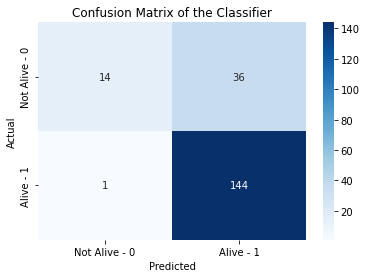

In [21]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Not Alive - 0', 'Alive - 1'])

<em><strong>Creating/updating model performance dictionary</strong></em>

In [22]:
# this code has to be run only the first time the models are run,
# if more comparissons are required, then the next line of code should be
# run instead of this one to ensure that the new outputs are recorded into a
# new row in the model_performance

# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic (full 4)'],
           
    'AUC Score' : [logreg_auc_score],
    
    'Training Accuracy' : [logreg_train_score],
           
    'Testing Accuracy'  : [logreg_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)

# checking the results, uncomment when required
#model_performance

In [ ]:
# this code has to be run when comparissons of different models are required,
# if this is the first time running any model, the previous line of code should be run
# for this reason this cell has been frozen, until it is required.

# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'logreg (set_4_not scaled)',
                           'Training Accuracy'  : logreg_train_score,
                           'Testing Accuracy'   : logreg_test_score,
                           'AUC Score'          : logreg_auc_score,
                           'Confusion Matrix'   : (logreg_tn,
                                                   logreg_fp,
                                                   logreg_fn,
                                                   logreg_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>KNN</strong><br>
<em><strong>Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and comparison among models.</strong></em>

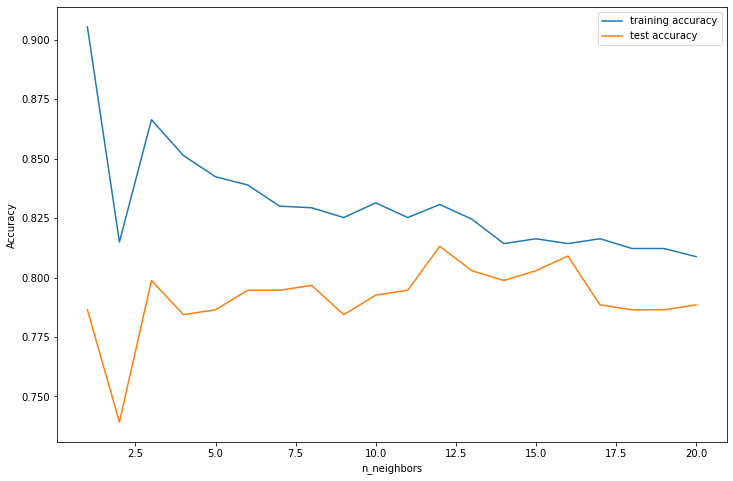

The optimal number of neighbors is: 12


In [23]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = GOT_data,
                                  y_data        = GOT_target,
                                  response_type = 'class')

In [24]:
# INSTANTIATING a KNN regression model
KNN = KNeighborsClassifier(n_neighbors = opt_neighbors)

# FITTING the training data
KNN_fit = KNN.fit(x_train, y_train)

# PREDICTING based on the testing set
KNN_pred = KNN_fit.predict(x_test)

# saving scoring data for future use
KNN_train_score = KNN_fit.score(x_train, y_train).round(4) # accuracy
KNN_test_score  = KNN_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
KNN_auc_score = roc_auc_score(y_true  = y_test,
                              y_score = KNN_pred).round(decimals = 4)

<em><strong>Confusion matrix:</strong></em> unpacking and visualizing the confusion matrix following the previously defined format.

In [25]:
# unpacking the confusion matrix
KNN_tn, \
KNN_fp, \
KNN_fn, \
KNN_tp = confusion_matrix(y_true = y_test, y_pred = KNN_pred).ravel()

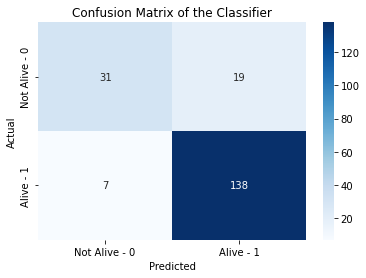

In [26]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = KNN_pred,
          labels = ['Not Alive - 0', 'Alive - 1'])

<em><strong>Updating model performance</strong></em>

In [27]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'KNN (set_4_not scaled)',
                           'Training Accuracy'  : KNN_train_score,
                           'Testing Accuracy'   : KNN_test_score,
                           'AUC Score'          : KNN_auc_score,
                           'Confusion Matrix'   : (KNN_tn,
                                                   KNN_fp,
                                                   KNN_fn,
                                                   KNN_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>Decision tree classifier</strong><br>
<em><strong>Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and comparison among models.</strong></em>
<br>

In [28]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the DTC with the "logit_sig_4" set of variables given that the selected GMB
# model runs on the "logit_full" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_sig_4']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################

# INSTANTIATING a DecisionTreeClassifier regression model
DTC = DecisionTreeClassifier(max_depth = 8, random_state = 219, min_samples_leaf = 1, class_weight= 'balanced')

# FITTING the training data
DTC_fit = DTC.fit(x_train, y_train)

# PREDICTING based on the testing set
DTC_pred = DTC_fit.predict(x_test)

# saving scoring data for future use
DTC_train_score = DTC_fit.score(x_train, y_train).round(4) # accuracy
DTC_test_score  = DTC_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
DTC_auc_score = roc_auc_score(y_true  = y_test,
                              y_score = DTC_pred).round(decimals = 4)

<em><strong>Confusion matrix:</strong></em> unpacking and visualizing the confusion matrix following the previously defined format.

In [29]:
# unpacking the confusion matrix
DTC_tn, \
DTC_fp, \
DTC_fn, \
DTC_tp = confusion_matrix(y_true = y_test, y_pred = DTC_pred).ravel()

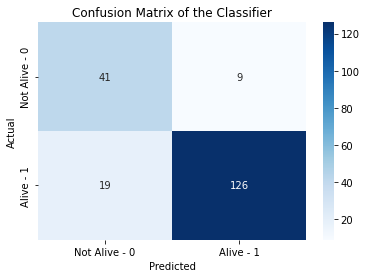

In [30]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = DTC_pred,
          labels = ['Not Alive - 0', 'Alive - 1'])

The previous codes produced a matrix from which the metrics below could be calculated, taking into account a model that used scaled data and the set of variables # 4 "logit_sig_4":<br>
-Accuracy: 0.86<br>
-Precision: 0.93<br>
-Sensitivity: 0.87<br>
-Specificity: 0.82<br>
<br>
From this it can be seen that the model was good at correctly predicting the number of times that a character would be alive over the total number of times that the model predicted that a character would be alive. That is why there's a small amount of cases where the model incorrectly predicted a character would be alive when it actually wasn't. In this same context, the model had a small quantity of cases where it predicted a character wouldn't be alive when it actually was alive. Also, the training and testing scores have a gap that is below 0.05. 
<br><br>
For these reasons, and because the model has an AUC of 0.84, it is selected as a good candidate to have its hyperparameters tunned in the later sections.
<br>

<em><strong>Updating model performance</strong></em>

In [31]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'DTC (set_4)',
                           'Training Accuracy'  : DTC_train_score,
                           'Testing Accuracy'   : DTC_test_score,
                           'AUC Score'          : DTC_auc_score,
                           'Confusion Matrix'   : (DTC_tn,
                                                   DTC_fp,
                                                   DTC_fn,
                                                   DTC_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>Random Forest</strong><br>
<em><strong>Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and 
comparison among models.</strong></em>

In [32]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the RFC with the "logit_sig_4" set of variables given that the selected GMB
# model runs on the "logit_full" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_sig_4']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################

# INSTANTIATING a RandomForestClassifier regression model
RFC = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 219, class_weight= 'balanced')

# FITTING the training data
RFC_fit = RFC.fit(x_train, y_train)

# PREDICTING based on the testing set
RFC_pred = RFC_fit.predict(x_test)

# saving scoring data for future use
RFC_train_score = RFC_fit.score(x_train, y_train).round(4) # accuracy
RFC_test_score  = RFC_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
RFC_auc_score = roc_auc_score(y_true  = y_test,
                              y_score = RFC_pred).round(decimals = 4)

<em><strong>Confusion matrix:</strong></em> unpacking and visualizing the confusion matrix following the previously defined format.

In [33]:
# unpacking the confusion matrix
RFC_tn, \
RFC_fp, \
RFC_fn, \
RFC_tp = confusion_matrix(y_true = y_test, y_pred = RFC_pred).ravel()

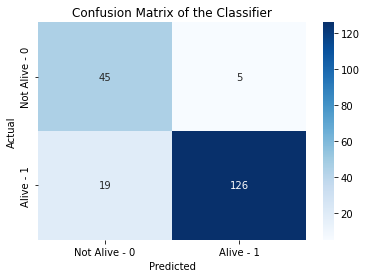

In [34]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = RFC_pred,
          labels = ['Not Alive - 0', 'Alive - 1'])

The previous codes produced a matrix from which the metrics below could be calculated, taking into account a model that used scaled data and the set of variables # 4 "logit_sig_4":<br>
-Accuracy: 0.88<br>
-Precision: 0.96<br>
-Sensitivity: 0.87<br>
-Specificity: 0.90<br>
<br>
From this it can be seen that the model was good at correctly predicting the number of times that a character would be alive over the total number of times that the model predicted that a character would be alive. That is why there's a small amount of cases where the model incorrectly predicted a character would be alive when it actually wasn't. In this same context, the model had a small quantity of cases where it predicted a character wouldn't be alive when it actually was alive. Also, the training and testing scores have a gap that is below 0.05. 
<br><br>
For these reasons, and because the model has an AUC of 0.88, it is selected as a good candidate to have its hyperparameters tunned in the later sections.
<br>

<em><strong>Updating model performance</strong></em>

In [35]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'RFC (set_4_scaled)',
                           'Training Accuracy'  : RFC_train_score,
                           'Testing Accuracy'   : RFC_test_score,
                           'AUC Score'          : RFC_auc_score,
                           'Confusion Matrix'   : (RFC_tn,
                                                   RFC_fp,
                                                   RFC_fn,
                                                   RFC_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>Feature Importance Plotting</strong><br>
The following plot was developed when the Random Forest Regression was run on the full model, without scaling the data to be able to determine the features that had the biggest importance and generate other preferred dictionaries to be tested among every model.
<br>
From the gap it was possible to determine that the most important features were time_frame, popularity, book4,  relatives_dead_by_culture and all_books.
<br>

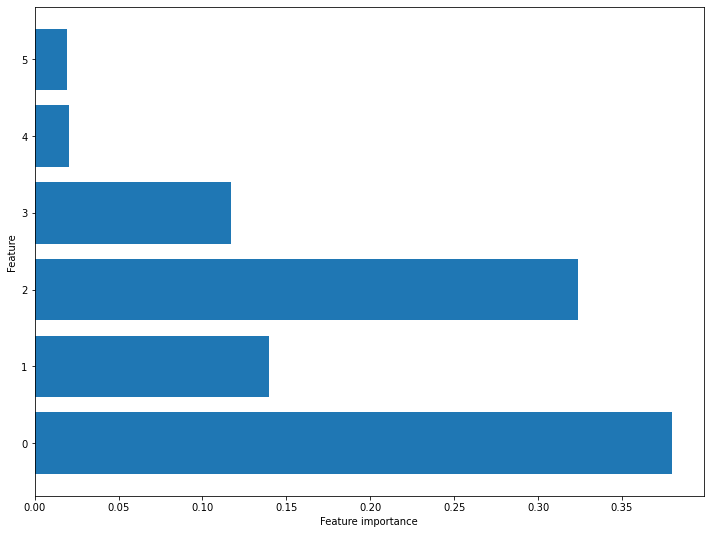

In [36]:
# plotting feature importance
plot_feature_importances(RFC_fit,
                         train = x_train,
                         export = True)

<strong>Gradient Boosting Machine</strong><br>
<em><strong>Model Instantiating, model fitting, model predicting and saving of scoring data to be used for evaluation and comparison among models.</strong></em>

In [37]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the GBM with the "logit_full" set of variables given that the selected DTC and RFC
# models run on the "logit_sig_4" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_full']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################

# INSTANTIATING a GradientBoostingClassifier regression model
GBM = GradientBoostingClassifier(max_depth = 8, random_state = 219)

# FITTING the training data
GBM_fit = GBM.fit(x_train, y_train)

# PREDICTING based on the testing set
GBM_pred = GBM_fit.predict(x_test)

# saving scoring data for future use
GBM_train_score = GBM_fit.score(x_train, y_train).round(4) # accuracy
GBM_test_score  = GBM_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
GBM_auc_score = roc_auc_score(y_true  = y_test,
                              y_score = GBM_pred).round(decimals = 4)

<em><strong>Confusion matrix:</strong></em> unpacking and visualizing the confusion matrix following the previously defined format.

In [38]:
# unpacking the confusion matrix
GBM_tn, \
GBM_fp, \
GBM_fn, \
GBM_tp = confusion_matrix(y_true = y_test, y_pred = GBM_pred).ravel()

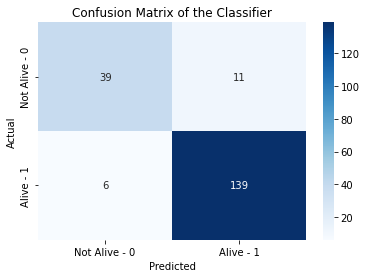

In [39]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = GBM_pred,
          labels = ['Not Alive - 0', 'Alive - 1'])

The previous codes produced a matrix from which the metrics below could be calculated, taking into account a model that used scaled data and the full set of variables "logit_full":<br>
-Accuracy: 0.91<br>
-Precision: 0.93<br>
-Sensitivity: 0.96<br>
-Specificity: 0.78<br>
<br>
From this it can be seen that the model was good at correctly predicting the number of times that a character would be alive over the total number of times that the model predicted that a character would be alive. That is why there's a small amount of cases where the model incorrectly predicted a character would be alive when it actually wasn't. In this same context, the model had a small quantity of cases where it predicted a character wouldn't be alive when it actually was alive. However, the training and testing scores have a gap that is over 0.05.<br>
Also, on this model we had a decrease on the number of times the model predicted that a character would NOT be alive over the number of times the character is actually not alive when compared to other models.
<br><br>
For these reasons, and because the model has an AUC of 0.87, it is selected as a good candidate to have its hyperparameters tunned in the later sections expecting to reduce the training and testing gap.
<br>

<em><strong>Updating model performance</strong></em>

In [40]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'GBM (set_full_scaled)',
                           'Training Accuracy'  : GBM_train_score,
                           'Testing Accuracy'   : GBM_test_score,
                           'AUC Score'          : GBM_auc_score,
                           'Confusion Matrix'   : (GBM_tn,
                                                   GBM_fp,
                                                   GBM_fn,
                                                   GBM_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

In [ ]:
# # sending model results to Excel
# # used to analyze on Excel and Jupyter the outputs at the same time.
# model_performance.to_excel('./classification_model_performance.xlsx',
#                            index = False)

<strong>Hyperparameter Tuning</strong><br>
<br>
After determining that the Decision Tree Classifier, the Random Forest Classifier and the Gradient Boosting Machine provided the best outcomes/scores for their respective tested significant features, it was decided to tune the hyperparameters of these models.
<br>
In the following section, each of these models is tunned by using the randomized search cross validation to determine the optimal parameters and its respective training AUC. Then these parameters are used to run the classifications again on the corresponding significant feature group for each model to compare the tuned scores with the previous obtained ones.
<br>

<strong>Decision Tree Hyperparameter Tuning</strong><br>
The following cell contains the hyperparameter tuning for the Decision Classifier.
<br><br>
The parameters that were chosen to be optimized were criterion, splitter, class weight, max depth and minimum samples leaf.
<br><br>
At the beginning the ranges for these parameters were defined to be to small, so no benefit was identified from the tuning. However, after getting more familiar with the documentation of this classifier, the following ranges were used. It is important to mention that the default values for each parameter are always included inside the hyperparameter space.
<br>

In [14]:
# declaring a hyperparameter space
criterion_range = ['gini', 'entropy'] 
splitter_range  = ['best', 'random']
class_range     = ['balanced', None]
depth_range     = np.arange(1, 8, 1)
leaf_range      = np.arange(1, 150, 1)

# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_range,
              'splitter'         : splitter_range,
              'class_weight'     : class_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : leaf_range}

# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)

# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))

# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(x_scaled_df, GOT_target)

# PREDICT step is not needed

# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced'}
Tuned Training AUC: 0.7762


In [15]:
# best estimators based on RandomizedSearchCV
tuned_tree_cv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=3, random_state=219)

<strong>Random Forest Hyperparameter Tuning</strong><br>
The following cell contains the hyperparameter tuning for the Random Forest Classifier.
<br><br>
The parameters that were chosen to be optimized were the number of estimators, max depth, class weight, minimum samples leaf, criterion and bootstrap.
<br><br>
At the beginning the warm start parameter was intended to be optimized as well, but a warning was obtained because the class weight was set to "balanced" or "unbalanced" and this could produce inconsistent result if combined with the warm start. So this last parameter was not included. It is important to mention that the default values for each parameter are always included inside the hyperparameter space.

In [20]:
# declaring a hyperparameter space
estimator_range  = np.arange(100, 1000, 250)
depth_range      = np.arange(1, 8, 1)
class_range      = ['balanced', 'balanced_subsample']
leaf_range       = np.arange(1, 35, 5)
criterion_range  = ['gini', 'entropy']
bootstrap_range  = [True, False]

# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_range,
              'max_depth'        : depth_range,
              'class_weight'     : class_range,
              'min_samples_leaf' : leaf_range,
              'criterion'        : criterion_range,
              'bootstrap'        : bootstrap_range}

# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)

# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))

# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(x_scaled_df, GOT_target)

# PREDICT step is not needed

# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

Tuned Parameters  : {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Tuned Training AUC: 0.7762


In [30]:
# best estimators based on RandomizedSearchCV
forest_cv.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=219)

<strong>Gradient Boosting Machine Hyperparameter Tuning</strong><br>
The following cell contains the hyperparameter tuning for the Gradient Boosting Machine.
<br><br>
The parameters that were chosen to be optimized were learning rate, number of estimators, max depth and minimum samples leaf and warm start.
<br><br>
At the beginning the ranges for these parameters were defined to be to small, so no benefit was identified from the tuning. However, after getting more familiar with the documentation of this classifier, the following ranges were used. It is important to mention that the default values for each parameter are always included inside the hyperparameter space.
<br>

In [30]:
# declaring a hyperparameter space
learn_range        = np.arange(0.1, 2.2, 0.5)
estimator_range    = np.arange(100, 1000, 200)
depth_range        = np.arange(1, 8, 1)
leaf_range         = np.arange(1, 50, 10)
warm_start_range   = [True, False]

# creating a hyperparameter grid
param_grid = {'learning_rate'    : learn_range,
              'n_estimators'     : estimator_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : leaf_range,
              'warm_start'       : warm_start_range}

# INSTANTIATING the model object without hyperparameters
gbm_grid = GradientBoostingClassifier(random_state = 219)

# GridSearchCV object
gbm_cv = RandomizedSearchCV(estimator           = gbm_grid,
                            param_distributions = param_grid,
                            cv                  = 3,
                            n_iter              = 1000,
                            scoring             = make_scorer(roc_auc_score,
                                                       needs_threshold = False))

# FITTING to the FULL DATASET (due to cross-validation)
gbm_cv.fit(x_scaled_df, GOT_target)

# PREDICT step is not needed

# printing the optimal parameters and best score
print("Tuned Parameters  :", gbm_cv.best_params_)
print("Tuned Training AUC:", gbm_cv.best_score_.round(4))

Tuned Parameters  : {'warm_start': False, 'n_estimators': 300, 'min_samples_leaf': 31, 'max_depth': 2, 'learning_rate': 0.6}
Tuned Training AUC: 0.7636


In [31]:
# best estimators based on RandomizedSearchCV
gbm_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.6, max_depth=2, min_samples_leaf=31,
                           n_estimators=300, random_state=219)

<strong>Hyperparameter Tuning continued: </strong>Run selected models after tuning.

<strong>Tuned Decision Tree</strong><br>
The model is run one more time using the best parameters obtained by the tunning process, scaled data and the set of variables # 4 "logit_sig_4":
<br>

In [41]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the tuned DTC with the "logit_sig_4" set of variables given that the selected GMB
# model runs on the "logit_full" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_sig_4']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################

# INSTANTIATING a DecisionTreeClassifier regression model
DTC_tuned = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy',
                                   max_depth = 5, min_samples_leaf = 3,
                                   splitter = 'best', random_state = 219)

# FITTING the training data
DTC_tuned_fit = DTC_tuned.fit(x_scaled_df, GOT_target)

# PREDICTING based on the testing set
DTC_tuned_pred = DTC_tuned_fit.predict(x_test)

# saving scoring data for future use
DTC_tuned_train_score = DTC_tuned_fit.score(x_train, y_train).round(4) # accuracy
DTC_tuned_test_score  = DTC_tuned_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
DTC_tuned_auc_score = roc_auc_score(y_true  = y_test,
                              y_score = DTC_tuned_pred).round(decimals = 4)

In [42]:
# unpacking the confusion matrix
DTC_tuned_tn, \
DTC_tuned_fp, \
DTC_tuned_fn, \
DTC_tuned_tp = confusion_matrix(y_true = y_test, y_pred = DTC_tuned_pred).ravel()

In [43]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'DTC_tuned (set_4_scaled)',
                           'Training Accuracy'  : DTC_tuned_train_score,
                           'Testing Accuracy'   : DTC_tuned_test_score,
                           'AUC Score'          : DTC_tuned_auc_score,
                           'Confusion Matrix'   : (DTC_tuned_tn,
                                                   DTC_tuned_fp,
                                                   DTC_tuned_fn,
                                                   DTC_tuned_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>Tuned Random Forest</strong><br>
The model is run one more time using the best parameters obtained by the tunning process, scaled data and the set of variables # 4 "logit_sig_4":
<br>

In [44]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the tuned RFC with the "logit_sig_4" set of variables given that the selected GMB
# model runs on the "logit_full" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_sig_4']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################

# building a model based on hyperparameter tuning results
# INSTANTIATING with best_estimator
RFC_tuned = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, max_depth = 5,
                                   criterion = 'entropy', class_weight = 'balanced', bootstrap = True,
                                   random_state = 219)

# FITTING to the FULL DATASET (due to cross-validation)
RFC_tuned_fit = RFC_tuned.fit(x_scaled_df, GOT_target)

# PREDICTING based on the testing set
RFC_tuned_pred = RFC_tuned_fit.predict(x_test)

# saving scoring data for future use
RFC_tuned_train_score = RFC_tuned.score(x_train, y_train).round(4) # accuracy
RFC_tuned_test_score  = RFC_tuned.score(x_test, y_test).round(4)   # accuracy
# saving the AUC score
RFC_tuned_auc = roc_auc_score(y_true  = y_test,
                              y_score = RFC_tuned_pred).round(4) # auc

In [45]:
# unpacking the confusion matrix
RFC_tuned_tn, \
RFC_tuned_fp, \
RFC_tuned_fn, \
RFC_tuned_tp = confusion_matrix(y_true = y_test, y_pred = RFC_tuned_pred).ravel()

In [46]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'RFC_tuned (set_4_scaled)',
                           'Training Accuracy'  : RFC_tuned_train_score,
                           'Testing Accuracy'   : RFC_tuned_test_score,
                           'AUC Score'          : RFC_tuned_auc,
                           'Confusion Matrix'   : (RFC_tuned_tn,
                                                   RFC_tuned_fp,
                                                   RFC_tuned_fn,
                                                   RFC_tuned_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

<strong>Tuned Gradient Boosting Machine</strong><br>
The model is run one more time using the best parameters obtained by the tunning process, scaled data and the full set of variables "logit_full":
<br>

In [47]:
#####################################################################
# this section is included to gurantee that the final table of the code includes
# the tuned GBM with the "logit_full" set of variables given that the selected DTC and RFC
# models run on the "logit_sig_4" variables set.

GOT_data   =  GOT.loc[ : , candidate_dict['logit_full']]
GOT_target =  GOT.loc[ : , 'isAlive']
# INSTANTIATING StandardScaler()
scaler = StandardScaler()
# FITTING the data
scaler.fit(GOT_data)
# TRANSFORMING the data
x_scaled     = scaler.transform(GOT_data)
# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 
# train/test split with scaled data or not scaled data
x_train, x_test, y_train, y_test = train_test_split(
            #GOT_data,    # used when needed to split with not scaled data
            x_scaled_df,  # #used when needed to split with scaled data
            GOT_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = GOT_target)
#####################################################################


# INSTANTIATING with best_estimator
gbm_tuned = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.6,
                                       max_depth = 2, min_samples_leaf = 31,
                                       random_state = 219, warm_start = False)

# FITTING to the FULL DATASET (due to cross-validation)
gbm_tuned_fit = gbm_tuned.fit(x_scaled_df, GOT_target)

# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)

# saving scoring data for future use
gbm_tuned_train_score = gbm_tuned_fit.score(x_train, y_train).round(4) # accuracy
gbm_tuned_test_score  = gbm_tuned_fit.score(x_test, y_test).round(4) # accuracy
# saving AUC score for future use
gbm_tuned_auc_score = roc_auc_score(y_true  = y_test,
                                    y_score = gbm_tuned_pred).round(decimals = 4)

In [48]:
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()

In [49]:
# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'         : 'GBM_tuned (set_full_scaled)',
                           'Training Accuracy'  : gbm_tuned_train_score,
                           'Testing Accuracy'   : gbm_tuned_test_score,
                           'AUC Score'          : gbm_tuned_auc_score,
                           'Confusion Matrix'   : (gbm_tuned_tn,
                                                   gbm_tuned_fp,
                                                   gbm_tuned_fn,
                                                   gbm_tuned_tp)},
                          ignore_index = True)

# checking the results, uncomment when required
#model_performance

Viewing each model's performance metrics.

In [50]:
model_performance.sort_values(by = 'AUC Score',
                              ascending = False)

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
7,GBM_tuned (set_full_scaled),0.8962,0.9132,0.9333,"(41, 9, 4, 141)"
3,RFC (set_4_scaled),0.8845,0.8350,0.8769,"(45, 5, 19, 126)"
6,RFC_tuned (set_4_scaled),0.8745,0.7915,0.8718,"(44, 6, 19, 126)"
4,GBM (set_full_scaled),0.8693,0.9754,0.9128,"(39, 11, 6, 139)"
5,DTC_tuned (set_4_scaled),0.8683,0.8018,0.8821,"(42, 8, 15, 130)"
2,DTC (set_4),0.8445,0.8355,0.8564,"(41, 9, 19, 126)"
1,KNN (set_4_not scaled),0.7859,0.8121,0.8667,"(31, 19, 7, 138)"
0,Logistic (full 4),0.6366,0.8001,0.8103,"(14, 36, 1, 144)"


<strong>Final results</strong><br>
By looking at every result, 35 original models were runed by using different regressors, scaled or not scaled data and different set of variables.
<br>
In the end, 8 models from the pre tunning phase were selected based on their AUC score, training and testing scores, gap between the latest, and interpretation of the confusion matrix outputs.<br>
From these 8 models, only 3 were selected to have its hyperparameters tuned. These were already mentioned before and will be included in the last comparison table at the end of the code.
<br>

<strong>Final models output and selection</strong>
<br>
The following table shows the summary of the 3 best models (before and after hyperparameter tuning), and the selected model to predict if a Game of Thrones character would be alive or not.
<br>

In [52]:
# comparing final results
print(f"""
Model                                 Training score       Testing score       AUC Score       TN, FP, FN, TP
---------------------------------     --------------       --------------      ----------      --------------
Decision Tree (set_4_scaled)          {DTC_train_score}               {DTC_test_score}                {DTC_auc_score}        {DTC_tn, DTC_fp, DTC_fn, DTC_tp}
Tuned Decision Tree (set_4_scaled)    {DTC_tuned_train_score}               {DTC_tuned_test_score}                {DTC_tuned_auc_score}        {DTC_tuned_tn, DTC_tuned_fp, DTC_tuned_fn, DTC_tuned_tp}

Random Forest (set_4_scaled)          {RFC_train_score}                {RFC_test_score}                {RFC_auc_score}        {RFC_tn, RFC_fp, RFC_fn, RFC_tp}        
Tuned Random Forest (set_4_scaled)    {RFC_tuned_train_score}               {RFC_tuned_test_score}                {RFC_tuned_auc}        {RFC_tuned_tn, RFC_tuned_fp, RFC_tuned_fn, RFC_tuned_tp}

GBM (full set_scaled)                 {GBM_train_score}               {GBM_test_score}                {GBM_auc_score}        {GBM_tn, GBM_fp, GBM_fn, GBM_tp}
Tuned GBM (full set_scaled) **        {gbm_tuned_train_score}               {gbm_tuned_test_score}                {gbm_tuned_auc_score}        {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}

Note: My final model selection is marked by using double **""")


Model                                 Training score       Testing score       AUC Score       TN, FP, FN, TP
---------------------------------     --------------       --------------      ----------      --------------
Decision Tree (set_4_scaled)          0.8355               0.8564                0.8445        (41, 9, 19, 126)
Tuned Decision Tree (set_4_scaled)    0.8018               0.8821                0.8683        (42, 8, 15, 130)

Random Forest (set_4_scaled)          0.835                0.8769                0.8845        (45, 5, 19, 126)        
Tuned Random Forest (set_4_scaled)    0.7915               0.8718                0.8745        (44, 6, 19, 126)

GBM (full set_scaled)                 0.9754               0.9128                0.8693        (39, 11, 6, 139)
Tuned GBM (full set_scaled) **        0.9132               0.9333                0.8962        (41, 9, 4, 141)

Note: My final model selection is marked by using double **
